# Calibration of the Z-axis in a laser scanning microscope

In this notebook, we present the procedure to calibrate the Z-axis scanner (e.g., piezo motor or varifocal lens) of a microscope. We used the calibration sample from Argolight. The reference patterns we used are the [3D crossing stairs](https://argolight.notion.site/Argo-SIM-v1-6973c253a418422cadf224a5e55dd2ea#cd7464ab67bf470b947ac0d33e640f84) with axial step Δz = 1 µm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import brighteyes_ism.dataio.mcs as mcs
import brighteyes_ism.analysis.Tools_lib as tool
import brighteyes_ism.analysis.Graph_lib as gr

from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans

import os

## Data loading
In this case, the data are stored as an hdf5 file generated by the [BrightEyes-MCS](https://github.com/VicidominiLab/BrightEyes-MCS) software.

In [2]:
path = r'\\iitfsvge101.iit.local\mms\Data MMS server\STED-ISM\SetupDiagnostics\calibrations\argolight\stairs\new_offset_5V'

for file in sorted( os.listdir(path) ):
    if file.endswith('.h5'):
        print(file)
        break

fullpath = os.path.join(path, file)
data, meta = mcs.load(fullpath)

data-17-10-2023-12-31-54.h5


To perform the acquisition, we used a 488 nm CW laser. The power is roughly 50 µW on the focal plane.<br>
The microscope is a custom ISM setup, equipped with a 60x/1.4 oil objective lens.<br>
The detector array size is 1.4 Airy Units.<br>
We print the metadata, to show the acquisition parameters.

In [3]:
meta.Print()

version       0.0.1
comment       
rangex        60.0
rangey        60.0
rangez        26.0
nbin          2
dt            10.0
nx            800
ny            800
nz            61
nrep          1
calib_x       17.303
calib_y       17.409
calib_z       5.13


The ISM data structure is (repetition, z, y, x, time, channel). <br>
Since we are not interested in having high-resolution, we keep only the spatial dimensions (z, y, x).

In [4]:
data = np.sum(data, axis = (0,4,5))

We crop the edges of the stack, because we are interested only in the stairway structures.

In [5]:
dset = data[:, 250:-250, 100:-100]

We have a look at the z-stack.

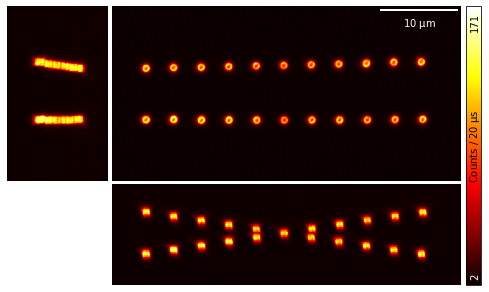

In [6]:
figsize = (7, 4.3)
fig = gr.ShowStack(dset, meta.dx, meta.dz/2, clabel = meta.pxdwelltime, projection = 'mip', figsize = figsize)

## Pre-processing

We want to measure only the center-of-mass of each step of the stairway.<br>
Thus, we sacrifice some resolution to denoise the dataset with a Gaussian filter.

In [7]:
dset = gaussian(dset, sigma = 2)
dset /= dset.max()

We convert the z-stack (Z, Y, X) to a point cloud where each row contains the 3D coordinates and the corresponding intensity value.

In [8]:
point_cloud_matrix = tool.point_cloud_from_img(dset)

We remove the background with the Otsu method.

In [9]:
thresh = threshold_otsu(dset)
cloud = point_cloud_matrix[ point_cloud_matrix[:, -1] > thresh ]

We look at the thresholded scatter plot.

Text(0.5, 0, 'z')

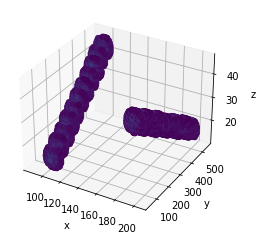

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cloud[:,1], cloud[:,2], cloud[:,0], c = cloud[:,3])
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')

## Data clustering

We perform K-Means clustering to identify each step.

In [11]:
model = KMeans(n_clusters = 22, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = model.fit_predict(cloud)

cm = model.cluster_centers_

We classify each stair using the y-coordinate.

Text(0.5, 0, 'z')

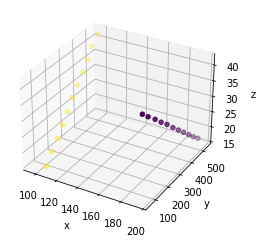

In [12]:
ym = cm[:, 1].mean()
cm_classes = cm[:, 1] < ym

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cm[:, 1], cm[:, 2], cm[:, 0], c=cm_classes)
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')

## Calibration

We sort the z-coordinates of each class in ascending order.<br>
Additionally, we convert the units into Volts.

In [13]:
z_a = np.sort( cm[cm_classes==0,0] ) * meta.dz / meta.calib_z # Volt

z_b = np.sort( cm[cm_classes==1,0] ) * meta.dz / meta.calib_z # Volt

We generate an array with spacing Δz = 1 µm.

In [14]:
x = np.arange(len(z_a)) # micrometers

We fit each stair to a line. The slope is the desired calibration value.

z_calib = 4.76 um/V


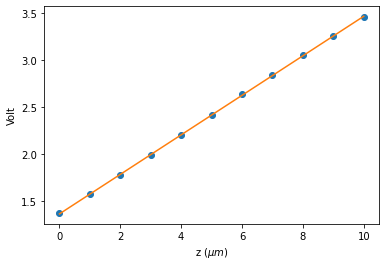

In [15]:
poly = np.polyfit(x, z_a, 1)

fit = np.poly1d(poly)

z_calib = 1 / poly[0] # um/Volt

plt.figure()
plt.plot( z_a, 'o' )
plt.plot( fit(x), '-' )
plt.xlabel(r'z $(\mu m)$' )
plt.ylabel(r'Volt' )

print( f'z_calib = {z_calib:.2f} um/V' )

We repeat the same process for the second stair. The two calibration values should match.

z_calib = 4.74 um/V


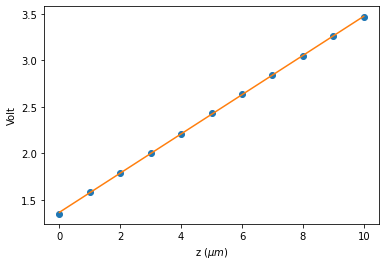

In [16]:
poly = np.polyfit(x, z_b, 1)

fit = np.poly1d(poly)

z_calib = 1 / poly[0] # um/Volt

plt.figure()
plt.plot( z_b, 'o' )
plt.plot( fit(x), '-' )
plt.xlabel(r'z $(\mu m)$' )
plt.ylabel(r'Volt' )

print( f'z_calib = {z_calib:.2f} um/V' )